<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>SGDClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import transformers as ppb 
import warnings
warnings.filterwarnings('ignore')

from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from transformers import AutoModel, AutoTokenizer 

RANDOM_STATE=12345
AIM = 0.75

In [2]:
pth1 = '/Users/ramilvaleev/Desktop/Yandex Projects/Проекты в работе/Toxic comments/toxic_comments.csv'
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

Something is wrong


In [3]:
data

In [4]:
data['text'] = data['text'].str.lower()

Удалим лишний столбец

In [5]:
data = data.drop('Unnamed: 0', axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
data['text'].apply(len).sort_values(ascending=False)

93787     5000
47612     5000
18151     5000
34352     5000
96100     5000
          ... 
15432        7
137400       6
136820       6
52336        6
119018       5
Name: text, Length: 159292, dtype: int64

In [8]:
data.groupby('toxic').describe()

text                                          
        count  unique                          top freq
toxic                                                  
0      143106  143076  "\n\n unblock request \n\n"    3
1       16186   16171      user:abd is muslim scum    3

Выборка не сбалансирована, разделим выборку на две отдельные, с позитивными и негативными комментариями, сделаем downsampling на обеих выборках, оставим по 500 комментариев для обучения с помощью BERT, чтобы компьютер не улетел в стратосферу, соединим выборки в одну.

In [9]:
comments = data.copy()
comments = comments.sample(4000)
display(comments.groupby('toxic').describe())
X = comments.drop('toxic', axis=1)
y = comments['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

print('Размер обучающего датасета:', X_train.shape)
print('Размер тестового датасета:', X_test.shape)

text                                                               
      count unique                                                top freq
toxic                                                                     
0      3594   3594  ", and nb i did not call anything ""a general ...    1
1       406    406  disruptive editing is it? you mean removing th...    1

Размер обучающего датасета: (3000, 1)
Размер тестового датасета: (1000, 1)


## Обучение

Возьмем готовую модель BERT.

In [10]:
model_name = "unitary/toxic-bert" 

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Создадим признаки для прогнозирования. Токенизируем текст в усеченной выборке. Параметр `truncation=True` будет укорачивать комментарии содержащие больше 512 слов, так как модель больше не поддерживает. 

In [11]:
def prepare_features(df):
    tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512)))
    n = 0
    for i in tokenized.values:
        if len(i) > n:
            n = len(i)

    padded = np.array([i + [0]*(n-len(i)) for i in tokenized.values])

    np.array(padded).shape

    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape

    batch_size = 1
    embeddings = []
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        del batch
        del attention_mask_batch
        del batch_embeddings
    return np.concatenate(embeddings)

In [12]:
X_train = prepare_features(X_train)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [13]:
X_test = prepare_features(X_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

Разделим выборку на признаки для моделирования и целевой признак.

In [14]:
print(X_train.shape )
print(X_test.shape) 
print(y_train.shape) 
print(y_test.shape)

(3000, 768)
(1000, 768)
(3000,)
(1000,)


Создадим обучающую и тестовую выборки.

In [15]:
def find_F1(model, grid_param):
    model_grid = GridSearchCV(
        estimator = model, param_grid = grid_param, cv=5, scoring='f1'
    )
    model_grid.fit(X_train, y_train)
    print('best parameters: ', model_grid.best_params_)
    print('best scrores: ', model_grid.best_score_)
    return model_grid.best_score_

In [16]:
def auc_roc_graph(model):
    probabilities_test = model.predict_proba(X_test)
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(y_test, probabilities_one_test)
    print('AUC-ROC =',auc_roc)
    fpr, tpr, _ = roc_curve(y_test, probabilities_one_test)
    plt.plot(fpr, tpr, label=f'AUC-ROC= {str(auc_roc)}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4);
    return auc_roc

### Логистическая регрессия

In [17]:
%%time
grid_param = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']}
f1_train_lr = find_F1(LogisticRegression(), grid_param)
f1_train_lr

best parameters:  {'solver': 'saga'}
best scrores:  0.9252698035519218
CPU times: user 46.3 s, sys: 2.62 s, total: 48.9 s
Wall time: 43.9 s


0.9252698035519218

In [18]:
model = LogisticRegression(solver='newton-cg')
model.fit(X_train, y_train)
pred = model.predict(X_test)
f1_lr = f1_score(y_test, pred)
print(f1_lr)

0.9064039408866996


AUC-ROC = 0.9923237040055507


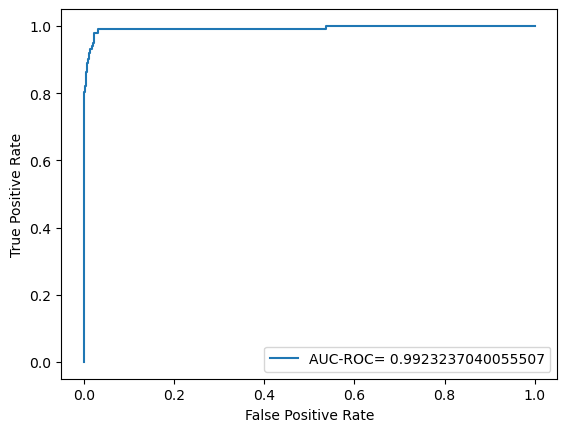

In [19]:
auc_lr = auc_roc_graph(model)

### CatBoost

In [20]:
%%time
cb_regressor = CatBoostClassifier() 

grid_param = {'iterations' : [300],
              'learning_rate':[0.1, 0.5, 0.8],
              'random_state':[RANDOM_STATE],
              'verbose':[100],
              'task_type':['GPU']}

f1_train_cat = find_F1(CatBoostClassifier(), grid_param)

0:	learn: 0.4469441	total: 19.5ms	remaining: 5.83s
100:	learn: 0.0028385	total: 1.22s	remaining: 2.4s
200:	learn: 0.0010503	total: 2.39s	remaining: 1.18s
299:	learn: 0.0005963	total: 3.54s	remaining: 0us
0:	learn: 0.4368025	total: 12.4ms	remaining: 3.7s
100:	learn: 0.0029216	total: 1.16s	remaining: 2.29s
200:	learn: 0.0010447	total: 2.34s	remaining: 1.15s
299:	learn: 0.0005782	total: 3.56s	remaining: 0us
0:	learn: 0.4410595	total: 13.1ms	remaining: 3.92s
100:	learn: 0.0030365	total: 1.93s	remaining: 3.79s
200:	learn: 0.0010953	total: 3.24s	remaining: 1.59s
299:	learn: 0.0006306	total: 4.39s	remaining: 0us
0:	learn: 0.4256612	total: 12.5ms	remaining: 3.75s
100:	learn: 0.0028204	total: 1.17s	remaining: 2.3s
200:	learn: 0.0009867	total: 2.33s	remaining: 1.15s
299:	learn: 0.0005441	total: 3.47s	remaining: 0us
0:	learn: 0.4109874	total: 12.6ms	remaining: 3.76s
100:	learn: 0.0019973	total: 1.34s	remaining: 2.65s
200:	learn: 0.0007559	total: 2.51s	remaining: 1.24s
299:	learn: 0.0004458	total:

In [21]:
%%time
cb_regressor = CatBoostClassifier(iterations = 300, learning_rate=0.1, verbose=100, task_type='GPU',
                        random_state=RANDOM_STATE)
cb_regressor.fit(X_train, y_train)
pred = model.predict(X_test)
f1_cat = f1_score(y_test, pred)
print(f1_cat)

0:	learn: 0.4340448	total: 13.2ms	remaining: 3.96s
100:	learn: 0.0035942	total: 1.66s	remaining: 3.26s
200:	learn: 0.0011564	total: 3.1s	remaining: 1.53s
299:	learn: 0.0006520	total: 4.26s	remaining: 0us
0.9064039408866996
CPU times: user 5.61 s, sys: 1.99 s, total: 7.6 s
Wall time: 5.23 s


AUC-ROC = 0.9923237040055507


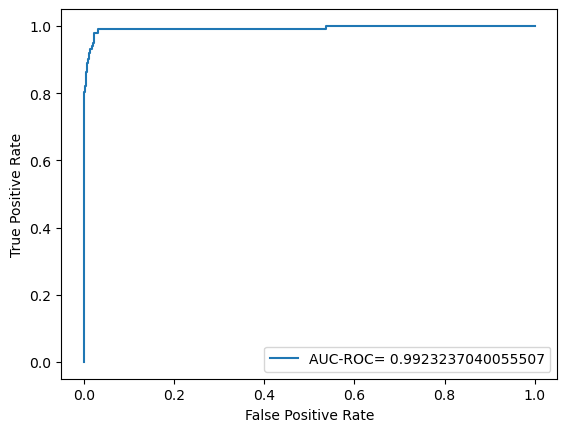

In [22]:
auc_cat = auc_roc_graph(model)

### Случайный лес

In [25]:
%%time
grid_param = {'n_estimators': [int(x) for x in range(20, 121, 20)],
              'max_depth': [x for x in range(1, 20, 2)],
              'random_state':[RANDOM_STATE]}
f1_train_rfc = find_F1(RandomForestClassifier(), grid_param)
f1_train_rfc

best parameters:  {'max_depth': 7, 'n_estimators': 20, 'random_state': 12345}
best scrores:  0.9346398812148345
CPU times: user 7min 29s, sys: 669 ms, total: 7min 30s
Wall time: 7min 31s


0.9346398812148345

In [26]:
model = RandomForestClassifier(max_depth=15, n_estimators=100, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
pred = model.predict(X_test)
f1_rfc = f1_score(y_test, pred)
print(f1_rfc)

0.91


AUC-ROC = 0.9908919701758829


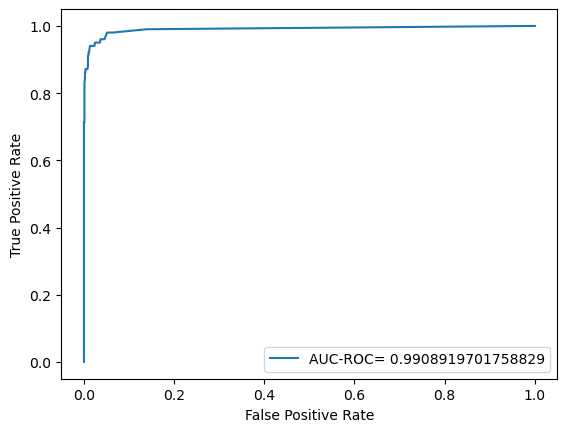

In [27]:
auc_rfc = auc_roc_graph(model)

### SGDClassifier

In [28]:
%%time
grid_params = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[RANDOM_STATE]}]
f1_train_sgdc = find_F1(SGDClassifier(), grid_params)

best parameters:  {'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'modified_huber', 'random_state': 12345}
best scrores:  0.9335497736826538
CPU times: user 1min 38s, sys: 23.6 s, total: 2min 2s
Wall time: 1min 22s


In [29]:
model = SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=0.1, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
pred = model.predict(X_test)
f1_sgdc = f1_score(y_test, pred)
print(f1_sgdc)

0.89


In [30]:
auc_sgdc = 'N/A'

In [32]:
index = ['Логистическая регрессия',
         'CatBoost',
         'Случайный лес',
         'SGDClassifier']
data = {'F1 на CV':[f1_train_lr,
                    f1_train_cat,
                    f1_train_rfc,
                    f1_train_sgdc],
        'F1 на тесте':[f1_lr,
                           f1_cat,
                           f1_rfc,
                           f1_sgdc],
        'Скорость обучения на CV, сек.':[43.9,
                           168,
                           451,
                           82],
       'AUC-ROC на тесте':[auc_lr,
                           auc_cat,
                           auc_rfc,
                           auc_sgdc]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Задание выполнено'] = scores_data['F1 на тесте'] > AIM
scores_data

,F1 на CV,F1 на тесте,"Скорость обучения на CV, сек.",AUC-ROC на тесте,Задание выполнено
Логистическая регрессия,0.925270,0.906404,43.9,0.992324,True
CatBoost,0.931704,0.906404,168.0,0.992324,True
Случайный лес,0.934640,0.910000,451.0,0.990892,True
SGDClassifier,0.933550,0.890000,82.0,N/A,True


## Выводы

В ходе работы над проектом было сделано:

Подготовленны данные обучения на моделях.
C помощью модели BERT подготовлены признаки и поделены данные на обучающую и тестовою выборку.
Обучены модели на CV.
Лучше всего себя по скорости обучения(44 сек.) и точности(0.93) предсказаний на обучающих данных показала модель логистической регрессии.

На тестовой выбоке по метрике F1 лучше всего себя показал случайный лес с показателем 0.91. Данная модель обладает большими показателями Precision и Accuracy. Это говорит нам, что токсичные комментарии находятся лучше. Однако разница между в точности между моделями незначительна. Следовательно можем рекомендовать логистическую регрессию как основную модель для данной задачи по совокупности скорости работы и целевой метрики.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны